In [167]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

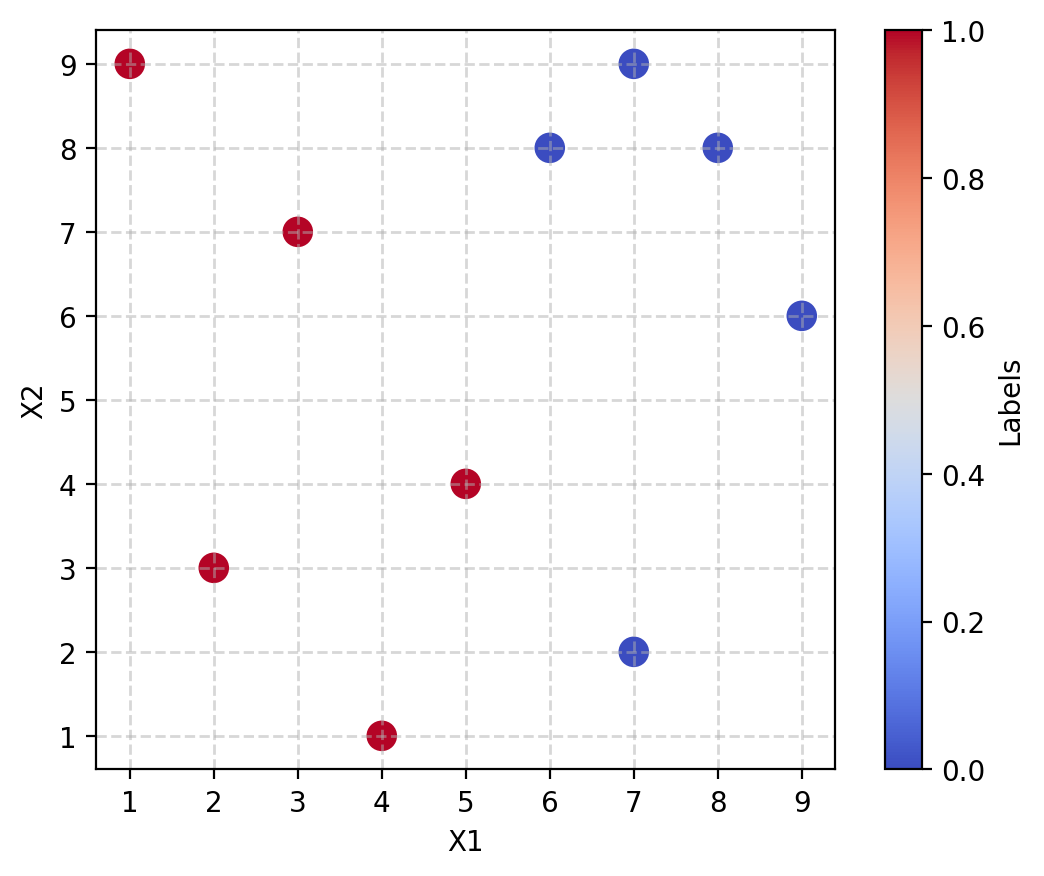

In [169]:
import matplotlib.pyplot as plt
import numpy as np

X_train = np.array([[1, 9], [2, 3], [4, 1], [3, 7], [5, 4], [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]])
y_train = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

def plot_dataset(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=100)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=0.5)
    plt.xticks(np.arange(min(X[:, 0]), max(X[:, 0])+1, 1))
    plt.yticks(np.arange(min(X[:, 1]), max(X[:, 1])+1, 1))
    plt.colorbar(label='Labels')
    plt.show()

plot_dataset(X_train, y_train)


In [170]:
class LSHForest:
    """
    For Khush Bhaiya:
    
    Parameters:
    - p (int): The number of random hyperplanes used in the LSHForest.
    - l (int): The number of hash tables in the forest.
    - k (int): The number of nearest neighbors to consider for prediction

    Methods:
    - pairwise_dist_numpy_norm: Computes the Euclidean distance between two points.
    - fit: Builds the LSHForest using the provided training data.
    - kneighbors: Finds the k-nearest neighbors for each test point. Returns the distances and indices of the neighbors.
    - predict: Predicts the output for each test point based on the labels of the nearest neighbors.

    """
    def __init__(self):
        self.p = None
        self.grouped_points_arr = []
        self.X_train = None
        self.l = None
        self.indices = None
        self.master_distances = []
        self.master_indices = []

    def pairwise_dist_numpy_norm(self,x: np.ndarray, y: np.ndarray) -> float:
        return np.linalg.norm(x - y)
    
    def fit(self, X_train, p, l):
        self.p = p
        self.l = l
        self.X_train = X_train
        X_aug = np.hstack([ np.ones((X_train.shape[0], 1)), X_train])
        for k in range(l):
            np.random.seed(k)
            R = np.random.randn(X_train.shape[1] + 1, self.p)
            signs = np.sign(X_aug @ R)
            grouped_points = {}
            for i, point in enumerate(signs):
                point_tuple = tuple(point)
                if point_tuple in grouped_points:
                    grouped_points[point_tuple].append(i)
                else:
                    grouped_points[point_tuple] = [i]
            self.grouped_points_arr.append(grouped_points)
        return
        
    def kneighbors(self, x_test, k):
        for q in x_test:
            distances = []
            indices = []
            q_aug = np.hstack([1, q])
            for j in range(self.l):
                np.random.seed(j)
                R = np.random.randn(X_train.shape[1] + 1, self.p)
                sign = tuple(np.sign(q_aug @ R))
                if sign not in self.grouped_points_arr[j]:
                    continue
                for point in self.grouped_points_arr[j][sign]:
                    dist = self.pairwise_dist_numpy_norm(self.X_train[point], q)
                    distances.append(dist)
                    indices.append(point)
            distances = np.array(distances)
            indices = np.array(indices)
            unique_distances, unique_indices = np.unique(distances, return_index=True)
            sorted_indices = unique_indices[np.argsort(unique_distances)]
            sorted_distances = np.sort(unique_distances)    
            if len(sorted_indices) < k:
                self.master_distances.append(sorted_distances)
                self.master_indices.append(sorted_indices)
            else:
                self.master_distances.append(sorted_distances[:k])
                self.master_indices.append(sorted_indices[:k])
        return self.master_distances, self.master_indices
        
    def predict(self,y_train):
        values = []
        for i in range(len(self.master_indices)):
            value = np.mean(y_train[self.master_indices[i]])
            values.append(value)
        return values

In [171]:
nbrs = LSHForest()
nbrs.fit(X_train,3,3) # 3 Hyperplanes, 3 Hash Tables

In [172]:
distances, indices = nbrs.kneighbors([[2,8],[2,4]],1)
distances, indices

([array([1.41421356]), array([1.])], [array([0]), array([1])])

In [173]:
output_label = nbrs.predict(y_train)
output_label

[1.0, 1.0]